In [1]:
import time
from datetime import datetime

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError as MSELoss
from tensorflow.keras.metrics import MeanAbsolutePercentageError as MAPEMetrics
from tensorflow.keras.metrics import MeanAbsoluteError as MAEMetrics
from tensorflow.keras.metrics import MeanSquaredError as MSEMetrics
from tensorflow.keras.metrics import R2Score

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
df = pd.read_csv('student_dataset/humi.csv', header=None, names=['date', 'pollution'])

print(df.head(), '\n', df.tail())

                         date  pollution
0  2024-11-19 13:50:41.183369       0.09
1  2024-11-19 13:50:42.195641       0.09
2  2024-11-19 13:50:43.200893       0.09
3  2024-11-19 13:50:44.201183       0.09
4  2024-11-19 13:50:45.206819       0.09 
                             date  pollution
1417  2024-11-19 14:14:23.504816       0.05
1418  2024-11-19 14:14:24.508797       0.07
1419  2024-11-19 14:14:25.515976       0.05
1420  2024-11-19 14:14:26.518948       0.05
1421  2024-11-19 14:14:27.522826       0.05


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(df.head())

                            pollution
date                                 
2024-11-19 13:50:41.183369       0.09
2024-11-19 13:50:42.195641       0.09
2024-11-19 13:50:43.200893       0.09
2024-11-19 13:50:44.201183       0.09
2024-11-19 13:50:45.206819       0.09


<Axes: title={'center': 'Pollution Over Time'}, xlabel='date'>

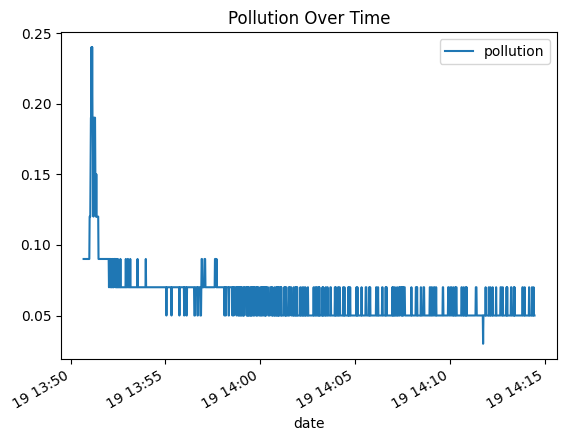

In [4]:
df.plot(y='pollution', kind='line', title='Pollution Over Time')

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1422 entries, 2024-11-19 13:50:41.183369 to 2024-11-19 14:14:27.522826
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1422 non-null   float64
dtypes: float64(1)
memory usage: 22.2 KB
None


In [6]:
print(df.describe())

         pollution
count  1422.000000
mean      0.062342
std       0.018861
min       0.030000
25%       0.050000
50%       0.050000
75%       0.070000
max       0.240000


In [7]:
zScore = StandardScaler()
np_normed = zScore.fit_transform(df)

In [8]:
df_normed = pd.DataFrame(np_normed, columns = ['pollution'])

In [9]:
print(df_normed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1422 non-null   float64
dtypes: float64(1)
memory usage: 11.2 KB
None


In [10]:
print(df_normed.describe())

          pollution
count  1.422000e+03
mean  -1.598971e-16
std    1.000352e+00
min   -1.715348e+00
25%   -6.545848e-01
50%   -6.545848e-01
75%    4.061783e-01
max    9.422665e+00


<Axes: title={'center': 'Pollution Over Time'}>

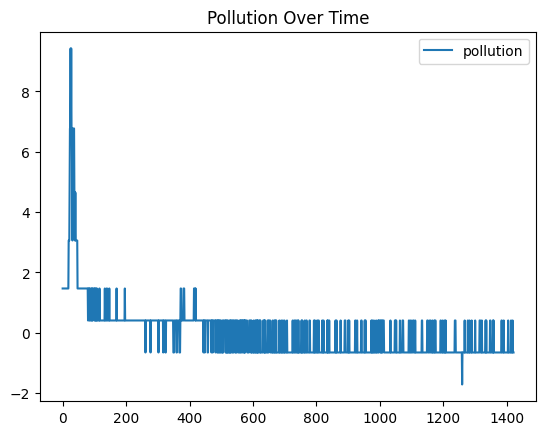

In [11]:
df_normed.plot(y='pollution', kind='line', title='Pollution Over Time')

In [12]:
val_length = 0.2
lr = 1e-3
labels_length = 30
seq_length = 15
data_features = 1
batch_size = 128
epochs = 1000

In [13]:
train_size = int((len(df_normed) - labels_length) * (1 - val_length))
val_size = int((len(df_normed) - labels_length) - train_size)
print('\nData length: ', len(df_normed), '\nTrain data size: ', train_size, '\nVal data size: ', val_size)

df_train = pd.DataFrame(df_normed.iloc[0:train_size, :])
df_valid = pd.DataFrame(df_normed.iloc[train_size:train_size+val_size, :])
df_test = pd.DataFrame(df_normed.iloc[train_size+val_size:, :])

print('\nData length: ', len(df_train), '\nData head: ', df_train.head(), '\nData tail: ', df_train.tail())
print('\nData length: ', len(df_valid), '\nData head: ', df_valid.head(), '\nData tail: ', df_valid.tail())


Data length:  1422 
Train data size:  1113 
Val data size:  279

Data length:  1113 
Data head:     pollution
0   1.466941
1   1.466941
2   1.466941
3   1.466941
4   1.466941 
Data tail:        pollution
1108  -0.654585
1109  -0.654585
1110  -0.654585
1111   0.406178
1112  -0.654585

Data length:  279 
Data head:        pollution
1113  -0.654585
1114  -0.654585
1115  -0.654585
1116  -0.654585
1117  -0.654585 
Data tail:        pollution
1387  -0.654585
1388  -0.654585
1389  -0.654585
1390   0.406178
1391  -0.654585


In [14]:
def create_dataset (X, y, look_back = 1):
    Xs, ys = [], []
 
    for i in range(0,len(X)-look_back):
        v = X[i:i+look_back]
        w = y[i+look_back]
        Xs.append(v)
        ys.append(w)
 
    return np.array(Xs), np.array(ys)

In [15]:
np_train = df_train.to_numpy()
np_valid = df_valid.to_numpy()
np_test = df_test.to_numpy()

X_train, y_train = create_dataset(np_train,np_train, seq_length)
X_valid, y_valid = create_dataset(np_valid,np_valid, seq_length)
X_test, y_test = create_dataset(np_test,np_test, seq_length)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(1098, 15, 1)
(1098, 1)
(264, 15, 1)
(264, 1)


In [17]:
def create_model(units):
    model = Sequential()
    model.add(Input(shape=(seq_length, data_features)))
    model.add(GRU(units = units*2, return_sequences=True))
    model.add(GRU(units = units*5, return_sequences=True))
    model.add(GRU(units = 1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=[MAEMetrics(), MSEMetrics(), MAPEMetrics(), tf.nn.log_poisson_loss, R2Score])
    return model

rnn_model_build = create_model(seq_length)

I0000 00:00:1733122157.139117 3156354 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [18]:
# def create_model(units):
#     model = Sequential()
#     model.add(Input(shape=(seq_length, data_features)))
#     model.add(SimpleRNN(units = units*2, return_sequences=True))
#     model.add(SimpleRNN(units = units*5, return_sequences=True))
#     model.add(SimpleRNN(units = 1))

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#                   loss='mse',
#                   metrics=[MAEMetrics(), MSEMetrics(), MAPEMetrics(), tf.nn.log_poisson_loss, R2Score])
#     return model

# rnn_model_build = create_model(seq_length)

In [19]:
rnn_model_build.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 30)         │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 15, 75)         │        24,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 1)              │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,279 (106.56 KB)

 Trainable params: 27,279 (106.56 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_path = 'model_store/11b_best_model.weights.h5'

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = EarlyStopping(monitor='loss', min_delta=0.000001, patience=20)
hist_callback = tf.keras.callbacks.History()
reduceLR_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=10, verbose=1, min_delta=0.000001)

In [21]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs=epochs,  
                        validation_data=(X_valid, y_valid),
                        batch_size=batch_size, shuffle=True,
                        # callbacks=[cp_callback, hist_callback, earlystop_callback, reduceLR_callback])
                        callbacks=[cp_callback, hist_callback, reduceLR_callback])
    return history

In [23]:
start_time = time.time()
st_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
st_time2 = datetime.now().strftime('%Y%m%d %H%M%S')
print('Start time: ', datetime.now())

train_history = fit_model(rnn_model_build)

print('Start time: ', st_time, '\nFinished time: ', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print('Overall training time: ', (time.time()-start_time)/3600, ' hours')

Start time:  2024-12-02 15:49:34.326942
Epoch 1/1000


I0000 00:00:1733122175.951526 3156548 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - log_poisson_loss: 0.8806 - loss: 0.8500 - mean_absolute_error: 0.5252 - mean_absolute_percentage_error: 74.7298 - mean_squared_error: 0.8500 - r2_score: 0.2630
Epoch 1: val_loss improved from inf to 0.16881, saving model to model_store/11b_best_model.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - log_poisson_loss: 0.8691 - loss: 0.8310 - mean_absolute_error: 0.5145 - mean_absolute_percentage_error: 73.0185 - mean_squared_error: 0.8310 - r2_score: 0.2776 - val_log_poisson_loss: 0.2312 - val_loss: 0.1688 - val_mean_absolute_error: 0.2183 - val_mean_absolute_percentage_error: 46.9781 - val_mean_squared_error: 0.1688 - val_r2_score: -0.1713 - learning_rate: 0.0010
Epoch 2/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - log_poisson_loss: 0.8305 - loss: 0.2770 - mean_absolute_error: 0.3076 - mean_absolute_percentage_error: 52.6066 - mean_squared_error: 0.2770 - r2_score: 0.5143
Epoch 2: val_loss improved from 0.16881 to 0.16548, saving model to model_s

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


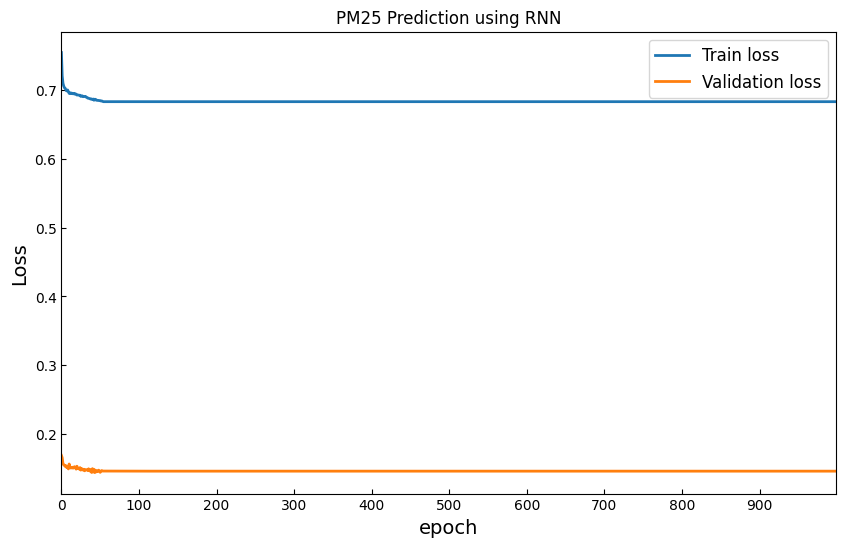

In [24]:
def plot_loss (history):
    fig, ax= plt.subplots(figsize = (10, 6))
    ax.set_xlim(0, len(history.history['loss'])-1)
#     ax.set_ylim(0, 1)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.xaxis.set_major_locator(MultipleLocator(0.1*len(history.history['loss'])))
#     ax.yaxis.set_major_locator(MultipleLocator(.2))
    
    plt.plot(history.history['loss'],linewidth=2)
    plt.plot(history.history['val_loss'],linewidth=2)
    csfont = {'fontname':'Times New Roman'}
    plt.title('PM25 Prediction using RNN')
    plt.ylabel('Loss',fontsize=14,**csfont)
    plt.xlabel('epoch',fontsize=14,**csfont)
    plt.legend(['Train loss', 'Validation loss'], loc='upper right',fontsize=12)

plot_loss(train_history)

In [25]:
rnn_model_build.load_weights(checkpoint_path)

In [26]:
prediction_result = rnn_model_build.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


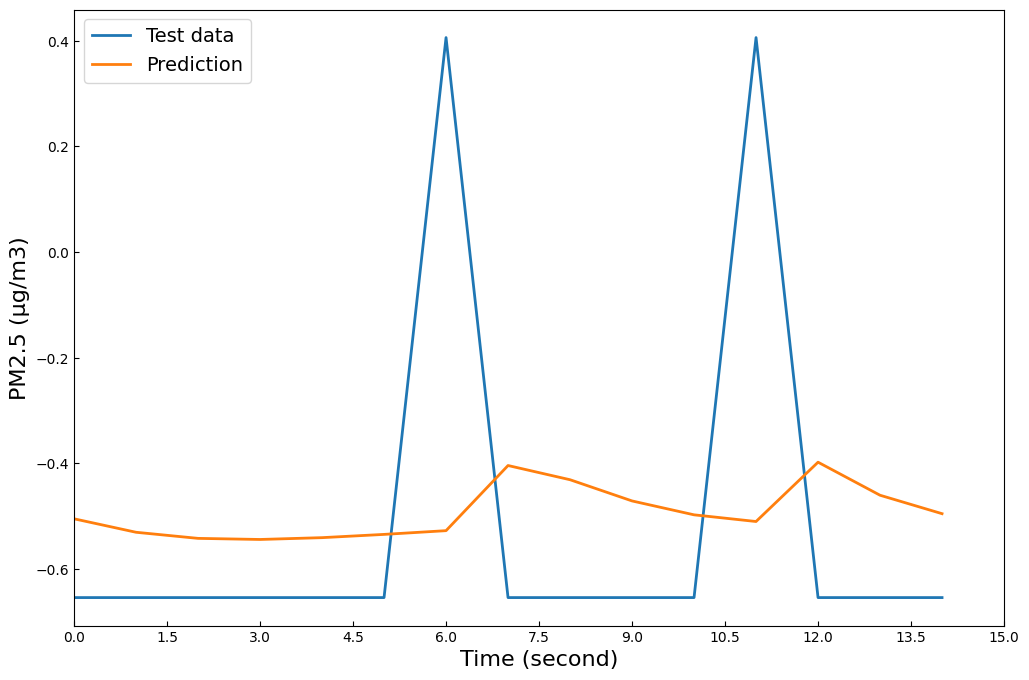

In [27]:
def plot_future(prediction, y_test):
    fig, ax= plt.subplots(figsize = (12, 8))
    ax.set_xlim(0, y_test.shape[0])
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.xaxis.set_major_locator(MultipleLocator(0.1*y_test.shape[0]))
    csfont = {'fontname':'Times New Roman'}
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),  label='Test data',linewidth=2)
    plt.plot(np.arange(range_future),np.array(prediction),label='Prediction',linewidth=2)
    plt.legend(loc='upper left',fontsize=14)
    plt.xlabel('Time (second)',fontsize=16,**csfont)
    plt.ylabel('PM2.5 (µg/m3)',fontsize=16,**csfont)
    
plot_future(prediction_result, y_test)